In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Submission 1 (can skip since it was not very good)

In [4]:
# removing columns that are either likely uninteresting for this task 
# or that we want to ignore for a first submission
train_x = train.drop(columns=['Personal URL','User Name','Id','Profile Text Color','Profile Page Color',
                    'Profile Theme Color','UTC Offset','Location','Profile Creation Timestamp',
                    'User Time Zone','Profile Image','User Language'])
test_x = test.drop(columns=['Personal URL','User Name','Id','Profile Text Color','Profile Page Color',
                    'Profile Theme Color','UTC Offset','Location','Profile Creation Timestamp',
                    'User Time Zone','Profile Image','User Language'])

#columns to convert to one_hot
to_encode_onehot =['Profile Cover Image Status','Profile Verification Status','Is Profile View Size Customized?',
                  'Location Public Visibility','Profile Category']
#columns to extract median from for imputation
values = {'Num of Followers': train['Num of Followers'].median(), 'Num of People Following': train['Num of People Following'].median(), 
          'Num of Status Updates': train['Num of Status Updates'].median(), 'Num of Direct Messages': train['Num of Direct Messages'].median(), 
          'Avg Daily Profile Visit Duration in seconds': train['Avg Daily Profile Visit Duration in seconds'].median(), 
          'Avg Daily Profile Clicks': train['Avg Daily Profile Clicks'].median()
          }

#convert to one_hot and impute values
train_x = pd.get_dummies(train_x,columns=to_encode_onehot)
train_x = train_x.fillna(value=values)

print(train_x.shape)

#get the labels
train_y = train_x['Num of Profile Likes'].copy()
train_x = train_x.drop(columns=['Num of Profile Likes'])


(7500, 24)


In [64]:
#convert to one_hot and impute values (for the test data)
test_x = pd.get_dummies(test_x,columns=to_encode_onehot)
test_x = test_x.fillna(value=values)

In [67]:
#split the data
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size = 0.3)

In [71]:
#train a simple model, evaluate accuracy and save predictions
lin = LinearRegression()
lin.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [104]:
preds = lin.predict(X_val)
preds[preds<1] = 1

In [105]:
np.mean((np.log10(preds) - np.log10(y_val+1))**2)

1.7455711726224254

In [144]:
submission_df = pd.DataFrame({'Id':test['Id'], 'Predicted': np.round(preds).astype(int)})
submission_df.to_csv('submission.csv',index=False)

# Submission 2, much better

In [51]:
# removing columns that are uninteresting for this task (or will be modified below)
train_x = train.drop(columns=['Personal URL','User Name','Id','Profile Text Color','Profile Page Color',
                    'Profile Theme Color','UTC Offset','Location','Profile Creation Timestamp',
                    'User Time Zone','Profile Image','User Language'])

#creating some new features
train_x['Has URL'] = pd.notna(train['Personal URL']).astype(float)
train_x['Profile Creation Year'] = train['Profile Creation Timestamp'].apply(lambda x: x[-4:]).apply(lambda x: float(x)).max()
#ignore all languages except the two most common: english and spanish. Convert to one hot
train_x['Language English'] = (train['User Language'] == 'en').astype(float)
train_x['Language Spanish'] = (train['User Language'] == 'es').astype(float)
train_x['Language Other'] = np.logical_not(np.logical_or((train['User Language'] == 'en'), (train['User Language'] == 'es'))).astype(float)

#columns to alter (either convert to onehot, impute values, or convert to log)
to_encode_onehot =['Profile Cover Image Status','Profile Verification Status','Is Profile View Size Customized?',
                  'Location Public Visibility','Profile Category']
values = {'Num of Followers': train['Num of Followers'].median(), 
          'Num of People Following': train['Num of People Following'].median(), 
          'Num of Status Updates': train['Num of Status Updates'].median(), 
          'Num of Direct Messages': train['Num of Direct Messages'].median(), 
          'Avg Daily Profile Visit Duration in seconds': train['Avg Daily Profile Visit Duration in seconds'].median(), 
          'Avg Daily Profile Clicks': train['Avg Daily Profile Clicks'].median(),
          'Has URL': train_x['Has URL'].median(),
          'Profile Creation Year': train_x['Profile Creation Year'].median()
          }
columns_as_log = ['Num of Followers','Num of People Following','Num of Status Updates',
                  'Num of Direct Messages','Avg Daily Profile Clicks']


#convert to one_hot and impute values and convert to log
train_x = pd.get_dummies(train_x,columns=to_encode_onehot)
train_x = train_x.fillna(value=values)
for col in columns_as_log:
    train_x[col] = np.log10(train_x[col]+1)

#get labels (and do log transform)
train_y = train_x['Num of Profile Likes'].copy()
train_y = np.log10(train_y+1)
train_x = train_x.drop(columns=['Num of Profile Likes'])

#split the data
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size = 0.3)

In [52]:
#do the same as above, but on the test data
test_x = test.drop(columns=['Personal URL','User Name','Id','Profile Text Color','Profile Page Color',
                    'Profile Theme Color','UTC Offset','Location','Profile Creation Timestamp',
                    'User Time Zone','Profile Image','User Language'])
test_x['Has URL'] = pd.notna(test['Personal URL']).astype(float)
test_x['Profile Creation Year'] = test['Profile Creation Timestamp'].apply(lambda x: x[-4:]).apply(lambda x: float(x)).max()
test_x['Language English'] = (test['User Language'] == 'en').astype(float)
test_x['Language Spanish'] = (test['User Language'] == 'es').astype(float)
test_x['Language Other'] = np.logical_not(np.logical_or((test['User Language'] == 'en'), (test['User Language'] == 'es'))).astype(float)

#
test_x = pd.get_dummies(test_x,columns = to_encode_onehot)
test_x = test_x.fillna(value=values)
for col in columns_as_log:
    test_x[col] = np.log10(test_x[col]+1)

In [53]:
lin2 = LinearRegression()
lin2.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [54]:
preds = lin2.predict(X_val)
preds[preds<0] = 0

In [55]:
np.mean((preds - y_val)**2)

0.6370570532512986

### Same as above but with SVM regression

In [56]:
from sklearn.svm import SVR

In [57]:
lin2 = SVR()
lin2.fit(train_x, train_y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [64]:
preds = lin2.predict(X_val)
preds[preds<0] = 0

In [72]:
preds[preds<0.3] = 0

In [73]:
np.mean((preds - y_val)**2)

0.5498792282677667

In [43]:
preds_real = 10**(preds)

In [44]:
preds_real

array([4877.89720043, 1887.06379187,  222.04239369, ..., 5755.97286971,
       1241.76022912,  273.48419822])

In [45]:
submission_df = pd.DataFrame({'Id':test['Id'], 'Predicted': np.round(preds_real).astype(int)})
submission_df.to_csv('submission2.csv',index=False)

# Some data visualisation to know which columns should be in log, and which columns are important predictors of the outcome variable

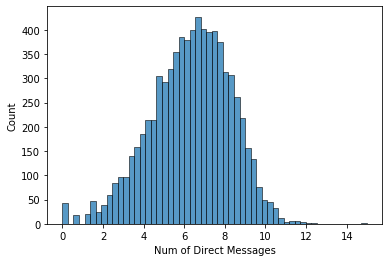

In [13]:
sns.histplot(np.log(train['Num of Direct Messages']+1))

In [9]:
train_x

,Num of Followers,Num of People Following,Num of Status Updates,Num of Direct Messages,Avg Daily Profile Visit Duration in seconds,Avg Daily Profile Clicks,Num of Profile Likes,Has URL,Profile Creation Year,Language English,...,Location Public Visibility_??,Location Public Visibility_Disabled,Location Public Visibility_Enabled,Location Public Visibility_disabled,Location Public Visibility_enabled,Profile Category_,Profile Category_business,Profile Category_celebrity,Profile Category_government,Profile Category_unknown
0,95763,4289,30809,873,14.792,1.5761,2815,0.0,2017.0,1.0,...,0,0,1,0,0,0,1,0,0,0
1,1018746,289,8150,290,8.183,11.2782,1242,0.0,2017.0,1.0,...,0,0,1,0,0,0,0,0,0,1
2,13444,1876,4698,227,31.823,0.5725,1559,0.0,2017.0,1.0,...,0,0,1,0,0,0,0,0,0,1
3,339168,1148,53216,4035,23.052,4.0265,6342,1.0,2017.0,1.0,...,0,0,1,0,0,0,1,0,0,0
4,9215,93,3271,130,8.418,3.9229,1078,1.0,2017.0,1.0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,6086,76,985,56,24.792,8.1106,1373,0.0,2017.0,1.0,...,0,1,0,0,0,0,0,0,0,1
7496,280190,38604,20652,172,26.006,0.8956,1407,0.0,2017.0,0.0,...,0,0,1,0,0,0,0,0,0,1
7497,21647,49,2348,271,15.030,2.8867,1235,0.0,2017.0,1.0,...,0,0,0,0,1,1,0,0,0,0
7498,89005,256,73830,346,11.948,1.7756,1105,0.0,2017.0,0.0,...,0,0,0,0,1,0,1,0,0,0


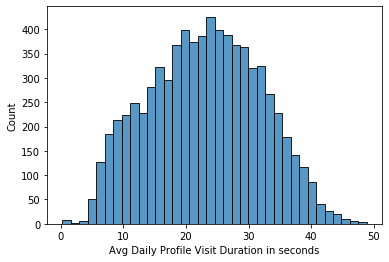

In [24]:
sns.histplot(train['Avg Daily Profile Visit Duration in seconds'])

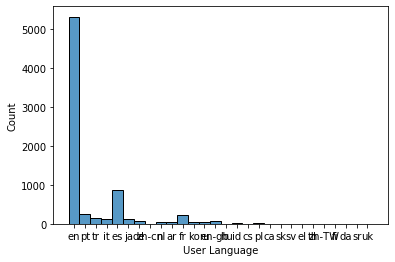

In [111]:
sns.histplot(train['User Language'])

Text(0.5, 0, 'log num of likes')

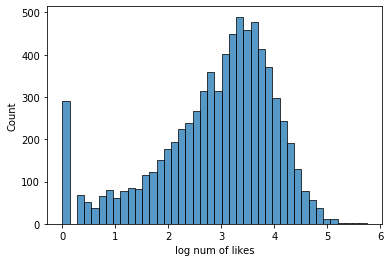

In [57]:
sns.histplot(np.log10(train['Num of Profile Likes']+1))
plt.xlabel('log num of likes')

/home/francis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/francis/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


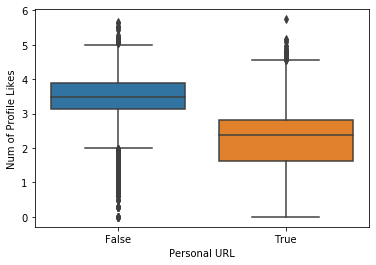

In [19]:
sns.boxplot(pd.notna(train['Personal URL']), np.log10(train['Num of Profile Likes']))#,alpha=0.005)

/home/francis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/francis/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


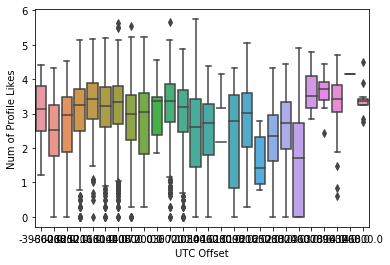

In [51]:
sns.boxplot(train['UTC Offset'],np.log10(train['Num of Profile Likes']))#,alpha=0.005)